In [2]:
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F

class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)

        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)

        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)

        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))

        return torch.cat((p1, p2, p3, p4), dim = 1)

## 2.GooleNet模型

In [3]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size = 1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size = 3, padding = 1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [4]:
X = torch.randn(1, 1, 96, 96)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


## 3.训练模型

loss 0.247, train acc 0.906, test acc 0.886
1794.1 examples/sec on cuda:0


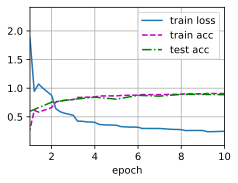

In [5]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [6]:
help(nn.Module)

Help on class Module in module torch.nn.modules.module:

class Module(builtins.object)
 |  Module() -> None
 |  
 |  Base class for all neural network modules.
 |  
 |  Your models should also subclass this class.
 |  
 |  Modules can also contain other Modules, allowing to nest them in
 |  a tree structure. You can assign the submodules as regular attributes::
 |  
 |      import torch.nn as nn
 |      import torch.nn.functional as F
 |  
 |      class Model(nn.Module):
 |          def __init__(self):
 |              super().__init__()
 |              self.conv1 = nn.Conv2d(1, 20, 5)
 |              self.conv2 = nn.Conv2d(20, 20, 5)
 |  
 |          def forward(self, x):
 |              x = F.relu(self.conv1(x))
 |              return F.relu(self.conv2(x))
 |  
 |  Submodules assigned in this way will be registered, and will have their
 |  parameters converted too when you call :meth:`to`, etc.
 |  
 |  .. note::
 |      As per the example above, an ``__init__()`` call to the parent c